## **Agrupamento de Séries Temporais de Evapotranspiração de Referência do Norte de Minas Gerais**


<center>
<table>

<img src="https://github.com/Hidrovales/Balanco_Hidrico/blob/main/Figuras/salinas_horizontal_jpg.jpg?raw=true" width="200"/>   <img src="https://github.com/Hidrovales/Balanco_Hidrico/blob/main/Figuras/COLORlogovertical.png?raw=true" width="200"/>
<tr>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</tr>
</table>

**Colaboradores:** Franciele A. Barbosa, Patrícia O. Lucas e Marcelo R. Vicente

**Notebook II =** Execução do algoritmos K-means e Ward e validação dos resultados 

As **séries temporais** são um tipo comum de dados dinâmicos que podem ser definidas como um conjunto de observações realizadas em sequência ao longo do tempo. A importância de seu **agrupamento** se destaca em:

*   Na descoberta de padrões, que podem disponibilizar informações valiosas através do conjunto de dados das séries temporais
*   Técnica exploratória e também como sub-rotina em algoritmos de mineração de dados mais complexos, como descoberta de regras, indexação, classificação e detecção de irregularidades

A **evapotranspiração** *($ET$)* é a combinação de dois processos, a evaporação e a transpiração. A **evapotranspiração de referência** ($ET_0$) é a taxa de evapotranspiração de uma superfície de referência. Onde a superfície de referência é semelhante a uma grande área de grama verde em crescimento, de altura uniforme, sombreando completamente o solo e com disponibilidade ilimitada de umidade do solo. A $ET_0$ é influenciada apenas por fatores climáticos, portanto, pode ser calculada a partir de dados meteorológicos.





## **Objetivos:**

Esse trabalho tem como principal objetivo a criação de zonas homogêneas de $ET_0$ através do agrupamento de séries temporais de $ET_0$ para o estado de Minas Gerais. 

## **Sobre os dados**

Após a leitura e tratamentos dos dados, foi aplicado aos dados a resolução da **alta dimensionalidade** e a **normalização Z**. Porém, os dados normalizados não foram utilizados, pois não apresentaram diferença nos resultados em relação aos dados sem a normalização.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#importando bibliotecas necessárias
from sklearn.cluster import AgglomerativeClustering, KMeans # geração dos modelos de agrupamento 
from sklearn.neighbors import kneighbors_graph # conectividade 
from scipy.spatial.distance import cdist # distâncias 
from scipy.cluster import hierarchy  # dendrograma
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import glob

#Para carregar os dados que estão online
import csv
import urllib
from sklearn import preprocessing
from google.colab import files

## **Lendo a base de dados sem a normalização**

Base de dados disponível no [GitHub](https://raw.githubusercontent.com/Hidrovales/ZonasHomogeneasEto/ad077174e2054886b78a252c30f64db3efdff94c/basededados_1.csv) como ***basededados_1.csv***.

In [ ]:
#Lendo os dados e definindo o nome das linhas
df = pd.read_csv('https://github.com/Hidrovales/ZonasHomogeneasEto/blob/main/basededados_1.csv?raw=true')
df = df.drop(['Unnamed: 0'], axis=1)
df.index=['JAN', 'FEV', 'MAR', 'ABR', 'MAI', 'JUN', 'JUL', 'AGO', 'SET', 'OUT', 'NOV', 'DEZ']
#df = df.T
df.head(3)

##**Plotagem do mapa de MG**

O conjunto de dados inclui dados diários observados coletados de medidores de chuva, bem como estações meteorológicas convencionais e automáticas do período de 1 de janeiro de 1980 a 31 de dezembro de 2016. E possui 5285 séries temporais de $ET_0$ (pontos) do estado de Minas Gerais, para melhor visualização foi plotado o mapa abaixo.

Base de dados diponível no [GitHub](https://raw.githubusercontent.com/Hidrovales/ZonasHomogeneasEto/main/coordenadas_corretas.csv) como ***coordenadas_corretas.csv***.

In [2]:
#Leitura da base de dados com a localização das cidades
df_l = pd.read_csv('https://raw.githubusercontent.com/Hidrovales/ZonasHomogeneasEto/main/coordenadas_corretas.csv',delimiter=',' )
df_l = df_l.drop(['Unnamed: 0'], axis=1)
df_l.head(3)

,lat,lon
0,-16.3005,-45.349
1,-16.3005,-45.249
2,-16.3005,-45.449


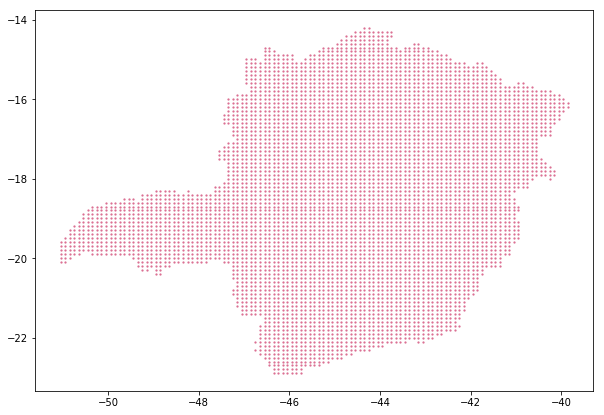

In [3]:
#Plotagem das 5285 séries temporais de ET_0 (pontos) do estado de Minas Gerais
plt.figure(figsize=(10,7))
plt.scatter(df_l['lon'],df_l['lat'], color='palevioletred', s=1.5);

## **Plotagem de uma amostra da série temporal**
Para a plotagem foi utilizada as cidades: Belo Horizonte, São Franscio, Ituiutaba e Silvianópolis.

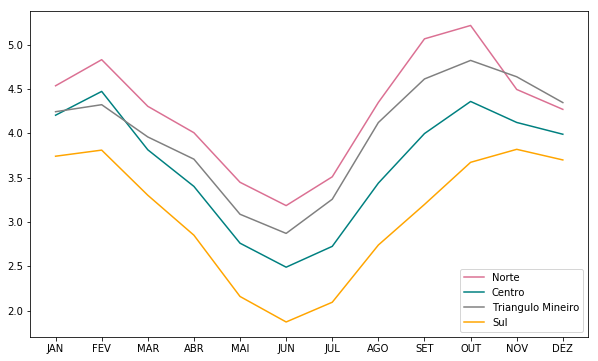

In [ ]:
#Localizando na base de dados das coordenadas das cidades escolhidas
coordenadas = df_l
BH = coordenadas.loc[(coordenadas['lon'] == -43.9490) & (coordenadas['lat'] == -19.8005)].index   #Belo Horizonte
SF = coordenadas.loc[(coordenadas['lon'] == -44.8490) & (coordenadas['lat'] == -16.0005)].index   #São Francisco
IT = coordenadas.loc[(coordenadas['lon'] == -49.949) & (coordenadas['lat'] == -18.8005)].index   #Ituiutaba
SV = coordenadas.loc[(coordenadas['lon'] == -45.849) & (coordenadas['lat'] == -22.0005)].index    #Silvianópolis

#plotagem da série temporal x mês de evapotranspiração
plt.figure(figsize=(10,6))

plt.plot(df.index, df.iloc[:,SF[0]:SF[0]+1], color='palevioletred')
plt.plot(df.index, df.iloc[:,BH[0]:BH[0]+1], color='teal')
plt.plot(df.index, df.iloc[:,IT[0]:IT[0]+1], color='gray')
plt.plot(df.index, df.iloc[:,SV[0]:SV[0]+1], color='orange')


plt.legend(['Norte','Centro', 'Triangulo Mineiro', 'Sul'], loc='lower right');
plt.show()



## **EXPERIMENTO 1**

###**Escolha do algoritmo e do número de clusters**

Para a **escolha do algoritmo** e do **número de clusters** que melhor se ajustasse ao problema, foi utilizada a **métrica da silhueta**. A silhueta é uma métrica que se baseia na proximidade entre os objetos de um cluster e na distância dos objetos de um cluster ao cluster mais próximo, permitindo avaliar a adequação de cada objeto ao seu cluster e também a qualidade de cada cluster individualmente. Seu valor é limitado pelo intervalo [-1,1], sendo a melhor partição aquela com valor 1.

Foram testados de **3 a 15 clusters**, escolhendo-se aquele com **maior silhueta**. 


###**K-means**

Execução da métrica silhueta para o algoritmo K-means.

In [ ]:
#Execução da métrica e os valores foram salvos na lista silhueta_list_kmeans
clusters_list = list(range(2, 16))
df_tranposto = df.T
silhueta_list_kmeans = []
for i in clusters_list:
  model_kmeans = KMeans(n_clusters=i)
  clusters_kmeans = model_kmeans.fit_predict(df_tranposto)
  silhueta_list_kmeans.append(silhouette_score(df_tranposto, clusters_kmeans))

In [ ]:
silhueta_list_kmeans

[0.5139796764219627,
 0.45836271587406247,
 0.45181552527344593,
 0.4664304621852921,
 0.41409058998768755,
 0.39940995119408923,
 0.38959810297488584,
 0.39810154732154396,
 0.4231509998785036,
 0.42722612646940145,
 0.4163421956839609,
 0.42462024111155133,
 0.3994661383345699,
 0.4033086615114805]

###**Ward**

Execução da métrica silhueta para o algoritmo de Ward.

In [ ]:
#Execução da métrica e os valores foram salvos na lista silhueta_list_ward
silhueta_list_ward = []
for i in clusters_list:
  model_ward = AgglomerativeClustering(n_clusters=i,linkage="ward")
  model_ward.fit(df_tranposto)
  clusters_ward = model_ward.labels_
  silhueta_list_ward.append(silhouette_score(df_tranposto, clusters_ward))

In [ ]:
silhueta_list_ward

[0.4864245095358984,
 0.42057752430978784,
 0.4100314431278544,
 0.4340972319570936,
 0.4197509356789342,
 0.39426436728907427,
 0.37392748220509164,
 0.37555087473575033,
 0.4014929728567307,
 0.3868364497826701,
 0.3784762164572633,
 0.37421226903043747,
 0.37067864414590823,
 0.3681444143501889]

###**Gráfico de comparação - métrica da silhueta**

Comparação da execução da métrica da silhueta do algoritmo K-means e Ward.

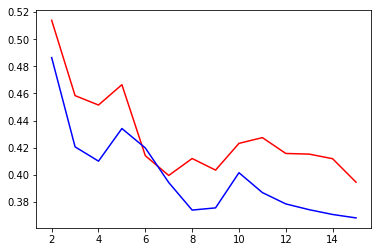

In [ ]:
#Plotando a comparação.
plt.plot(clusters_list, silhueta_list_kmeans, color='red')
plt.plot(clusters_list, silhueta_list_ward, color='blue')
pass

### **Tabela de comparação - métrica da silhueta**
Tabela de comparação entre a silhueta do K-means e Ward variando o número de clusters de 3 a 15.

In [ ]:
data = pd.DataFrame([clusters_list, silhueta_list_kmeans, silhueta_list_ward]) 
data = data.transpose() 
data.columns=['Num de Clusters','Média Silhouette - Kmeans','Média Silhouette - Ward'] 
data

,Num de Clusters,Média Silhouette - Kmeans,Média Silhouette - Ward
0,2.0,0.513980,0.486425
1,3.0,0.458363,0.420578
2,4.0,0.451439,0.410031
3,5.0,0.466430,0.434097
4,6.0,0.414044,0.419751
5,7.0,0.399471,0.394264
6,8.0,0.411966,0.373927
7,9.0,0.403422,0.375551
8,10.0,0.423145,0.401493
9,11.0,0.427381,0.386836


###**Modelo de agrupamento pela métrica da silhueta**

Plotando o modelo que apresentou o melhor resultado da silhueta para o algoritmo K-means e hierárquico de Ward.

###**K-means**

Plotando o modelo com 5 clusters.

('M\xc3\xa9dia silhueta: ', 0.4664304621852921)


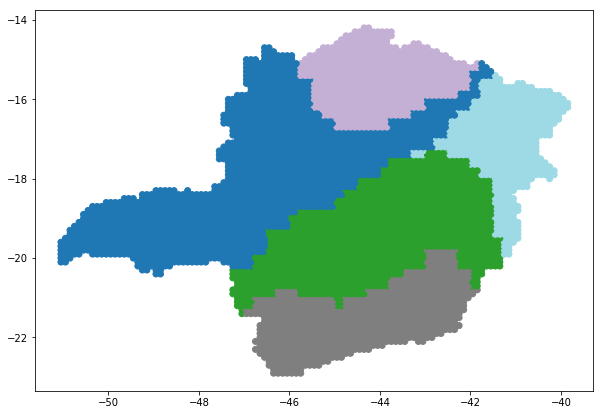

In [ ]:
df_tranposto = df.T
skm = KMeans(n_clusters=5)
clusters_kmeans = skm.fit_predict(df_tranposto)
silhouette_avg = silhouette_score(df_tranposto, clusters_kmeans)
print('Média silhueta: ', silhouette_avg)
plt.figure(figsize=(10,7))
plt.scatter(df_l['lon'],df_l['lat'], marker='o', c=clusters_kmeans, cmap=plt.cm.tab20_r)
pass

###**Ward**

Plotando modelo com 5 clusters.

('M\xc3\xa9dia silhueta: ', 0.4340972319570936)


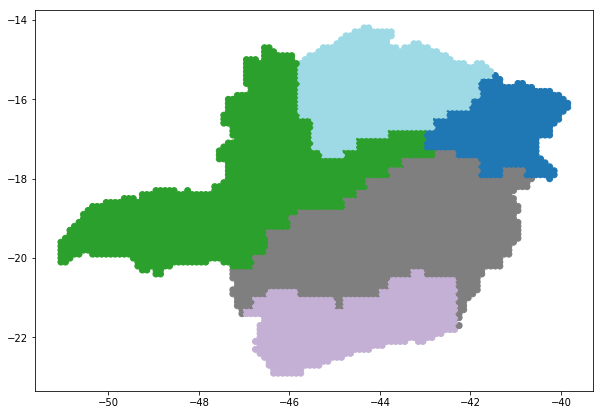

In [ ]:
# Crie o modelo de agrupamento hierárquico
model_ward = AgglomerativeClustering(n_clusters=5,linkage="ward")
model_ward.fit(df_tranposto)
clusters_ward = model_ward.labels_
silhouette_avg = silhouette_score(df_tranposto, clusters_ward)
print('Média silhueta: ', silhouette_avg)

plt.figure(figsize=(10,7))
plt.scatter(df_l['lon'],df_l['lat'], marker='o', c=clusters_ward, cmap=plt.cm.tab20_r)
pass

## **EXPERIMENTO 2**


Por se tratar de um problema não supervisionado, não há um elemento externo para guiar o aprendizado, ou seja, os dados não são rotulados. Além disso, para definir regiões homogêneas é indicado a utilização de vários métodos de análise de agrupamento, optando-se por aqueles cujos resultados sejam mais coerentes com o fenômeno em estudo. Dessa forma, realizou-se o **Experimento 2** para certificar se houve uma escolha correta do melhor número de *clusters* no Experimento 1. Para isso, escolheu-se os **5 melhores modelos** do algoritmo *K-means* do Experimento 1 e empregou-se a base de dados de validação para verificar qual desses modelos apresentam melhor estimativa de $ET_0$ usando o centróide dos clusters como rótulo. Como métrica, utilizou-se a raiz quadrática média **(RMSE)** *intra-cluster* e, em seguida, o valor médio do RMSE **(RMSE\_MEDIO)** *inter-cluster*.


### **Melhores modelos do algoritmo K-means**
O calculo do **RMSE** e **RMSE\_MEDIO** foi aplicado a cada um dos 5 valores, e foi escolhido o que apresentou o menor valor.

*   **Clusters 03=** 0.4562058322838353 (média silhueta)
*   **Clusters 04=** 0.4512992589926638 (média silhueta)
*   **Clusters 05=** 0.4664304621852921 (média silhueta)
*   **Clusters 10=** 0.42119289433273654 (média silhueta)
*   **Clusters 11=** 0.42748706780284507 (média silhueta)

### **Base de dados com novas estações**
A base possui dados de 62 estações e foi extraída do site do Instituto Nacional de Meteorologia - [INMET](https://portal.inmet.gov.br/normais), com 30 anos de dados coletados de estações meteorológicas no período de 1981 a 2010.
A base de dados também pode ser acessada pelo [GitHub](https://github.com/Hidrovales/ZonasHomogeneasEto/tree/main/basededados_2) como ***basededados_2*** ou ***basededados_2.zip***.

In [ ]:
#ESTAÇÕES
aimores = [4.723114830338618,4.920979505249866,4.31015768265992,3.5301661493326724,2.720192991920976,2.3200940177011717,2.4511290864161746,3.077376961882819,3.5920032363941665,4.018051303316687,4.080671508011124,4.231237418557578]
aracuai = [4.831308418558178,4.970600223164304,4.194699816127931,3.6127916404508023,3.0428088042428363,2.743863467954226,2.8848118401910496,3.4754231685434447,4.127260201452807,4.645527480191613,4.346838888458146,4.375057935097537]
araxa = [3.8442484385961206,4.093111694107743,3.7113735282925497,3.4900456643118702,2.8539947460917423,2.6638949843099438,3.004126829856919,3.7959342572177657,4.174028773440774,4.3417728500984785,4.08747368487228,3.6794671149130265]
arinos = [4.478915974516786,4.614507428573377,4.213322779077338,4.0122840446132715,3.340586344362122,3.094586648423558,3.543827754843766,4.3234913893371765,4.958893183387602,5.103490967630382,4.269315118010179,3.9749085559451784]
bambui = [3.8848557473121788,4.002042463602358,3.5021891033568386,3.1668508342002184,2.6029217874213733,2.325355758708308,2.5694696627032974,3.2285451346225797,3.698854763458652,4.061877965154603,3.9185433185593523,3.6597309592618017]
barbacena = [3.611752437106417,3.8808309885701537,3.1625339848528253,2.7477078749986763,2.09113388497416,1.8881219334058683,2.093468940947953,2.661890073982517,2.9434961886287274,3.3970259503122984,3.401674027903832,3.437328865494841]
bh = [4.224686211673531,4.491264274379025,3.933127559601652,3.5198484034319715,2.8826403638692897,2.6229506132664198,2.7891543468168734,3.500696603675705,3.9849728894623833,4.323948142671486,4.1459847849368865,3.9914912191746033]
bocaiuva = [4.990380969202199,4.756116448919922,4.4122439377433516,4.041914667956285,3.457492475268838,3.30637428660348,3.456203833518104,4.142511996121899,4.596021737504776,4.930503326620881,4.763842328063743,4.3718591911670135]
bomdespacho = [4.517290179082198,4.584550724024659,4.048872251834412,3.704815777114408,2.9645435033120235,2.71135431537642,2.9654899537628503,3.587197832527681,4.236240722300567,4.6289514287793185,4.286462654729259,3.9915290416673823]
buritis = [4.229178884649436,4.54322275028797,4.0787011880783535,3.810253095854448,3.3763225837036783,3.218963934935528,3.572431305952305,4.290763017071118,4.719169262602666,4.7962438690694364,4.109420873324943,3.9954971064893754]
caldas = [3.969213651195818,4.224716488046221,3.6516878313738887,3.1766008348203374,2.4936899721651344,2.3037796655873763,2.517251017763303,3.2038267433080723,3.612891135564437,3.876429351283614,3.916286953439189,3.8940957955262623]
caparao = [4.2009900624614716,4.336757373607537,3.7883857250777453,3.4262952031973004,2.6225961230607155,2.3380115985054686,2.5546760573604046,3.1323171155088234,3.5523723057160486,4.101775522302958,4.222777333036925,4.1375259342487]
capinopolis = [4.282332875826449,4.531298370760491,4.0434385198489,3.710383160373618,3.1364588876175468,3.032812753636166,3.508433706693405,4.384409684283993,4.805473465274648,4.8040586835458585,4.370446541465453,4.237004199319311]
caratinga = [4.007582245826736,4.434420857374887,3.8184515209414176,3.1867528943480306,2.489369968915622,2.252856784265232,2.4917058555972407,3.1341262581498266,3.5410471368497523,4.055013805377982,3.8754559601258816,3.7993658326745]
carbonita = [4.3024837652042764,4.498292336448716,3.81470208595316,3.7120367749293175,3.0350283912585456,2.76969159735286,3.0245148672146382,3.703958010235494,4.230132943838509,4.43320308043382,4.186033410883417,3.863205436535044]
caxambu = [4.416282959278945,4.471728033942759,3.92311013930575,3.4790115304827283,2.851753750815053,2.597560670772861,2.8921084833463846,3.5353579442445837,3.938019303820417,4.245285657916345,4.242470763423571,4.1360821026221934]
conceicaomatod = [3.9809710644145713,4.155167778965094,3.694009196978431,3.426105493516222,2.759060106214952,2.5065525186429904,2.7330253756855307,3.4577150301705832,3.7965817736105913,4.160115720533444,4.032755486590924,3.939157938332997]
coronelfabri = [4.478972020833806,4.739209679351166,4.1737288045110486,3.7484409010022213,2.998299273515185,2.6756413354433564,2.9317460806554254,3.512161086966604,3.9707901076019283,4.322663552869442,4.2068521135355965,4.137722705714232]
coronelpache = [4.215773967728433,4.609662088772952,3.83373406182715,3.282576276404562,2.544716528424339,2.266837393924883,2.3944476096316225,2.9826565921243287,3.5236672138788236,3.96923258193079,3.9608976538054135,3.9072735165225585]
curvelo = [4.8400258963257095,5.117380663727131,4.54122774512481,3.9684926992531784,3.3094628408453546,2.9463918155364874,3.24502630626078,4.156902844400022,4.974691292553066,5.160578487500158,4.576988921360259,4.4645792298208615]
diamantina = [3.976720019013906,3.9794113709571968,3.6201391179094853,3.244474645691892,2.66844126949602,2.416091362289592,2.587638468792877,3.1737057493596716,3.5668994838933474,3.9150225088302175,3.736978940197085,3.5834589504926013]
divinopolis = [4.50847537766578,4.626468802667775,4.065418738943009,3.771294694138896,3.2350215256517107,2.9230799052077905,3.2039860073189854,4.124211450286285,4.546549204738897,4.85961861861614,4.301623280355137,4.127792489412825]
espinosa = [4.802289303662432,5.154655926346144,4.550223215685969,4.195545719596415,3.7973606899162853,3.84958904419798,4.190985259816612,5.115686240809441,5.5831106039644185,5.609402172043913,4.6181009403510425,4.376812913058679]
fazmontealegre = [4.009472059362111,4.236519200965224,3.6033541342159587,3.144528094623632,2.470383719987517,2.195191325937646,2.427137835273705,3.200762262988577,3.7048969336042488,4.065252975229304,4.070453819402082,4.18356357555007]
florestal = [4.1041008961099585,4.165625297896884,3.8655475630743847,3.450589287091237,2.782520701367908,2.484334130102822,2.648025818221829,3.3282748549836216,3.7583174235356838,4.099697576625573,4.233942057700049,4.154855401131258]
formoso = [4.756285930015818,4.972054871946104,4.464365124771571,4.184464245447516,3.839175998611353,3.6158513319142593,3.810941657407812,4.660811946358239,5.260812978510918,5.278990653039347,4.47761408303381,4.31607246482068]
frutal = [4.783366925688143,4.8056471795248425,4.27155310357417,4.013041484203051,3.2289645158001874,3.0067994443341934,3.3236201359130466,4.139376986162391,4.708542086248354,4.969483391892162,4.482565409643514,4.410296525960928]
govvaladares = [4.273455843885369,4.4988047181196364,3.898037173982953,3.3717642289733214,2.6926179552598613,2.4617725818540857,2.647036140043669,3.2616292167922607,3.7184060134031545,4.072379995667731,4.00623752040503,3.8728126617980894]
ibirite = [4.440831811189222,4.722463667684237,4.240591616716007,3.848539283456695,3.1539712075191817,2.8857299018095923,3.109899955890373,3.833879110400354,4.4207399611885325,4.784822962910289,4.5385445953373935,4.287460885334363]
itamarandiba = [3.61671499178227,3.938614789410523,3.3527280230861205,2.972922829088788,2.4459381345783453,2.2255054774202567,2.3893173876980067,2.9350028585612176,3.264788730198223,3.5535183507152603,3.5033182947887367,3.5166178409082898]
ituiutaba = [4.67298535477588,4.747793423977759,4.181594649105949,3.786129599183487,3.193038621950007,3.0282324092661512,3.349109672466644,4.206173752830819,4.856758582801127,4.979941711852829,4.463571266536559,4.250060568053147]
janauba = [4.403042174488586,4.732646554312587,4.2490681399206975,4.189863865412069,3.80459347642974,3.638877803369765,3.8397206557103534,4.461641005585882,4.775700409438204,5.0688733580686485,4.6742185052466105,4.239045715650113]
januaria = [4.337626734351662,4.711852946164541,4.161205490469061,4.0627547935820525,3.537163145450065,3.3802763563729363,3.90808789453814,4.831310036941418,5.459036664138024,5.485800673875322,4.585088488282155,4.140147906046636]
joaomonlevade = [3.717771465432862,3.9971308660396168,3.400616104462959,3.06830477384393,2.4171459567999865,2.1345628907736933,2.3481983801373656,2.9153781515946298,3.2053330404509484,3.6751080574138335,3.688873819884264,3.5882078400504467]
joaopinheiro = [3.987411510540444,4.252670050865679,3.8972070893728463,3.6315341576506617,3.1415602425393603,2.9712336477079417,3.2672474710742434,4.03321046495111,4.361732685773543,4.637459498584419,4.287317770831542,3.8977342334991296]
juizfora = [4.357499270125886,4.6097221880505135,3.822309846235688,3.3294338634258653,2.6373537203287816,2.4193627593086298,2.6716386951660467,3.341171248955056,3.7599805685914167,4.042060266956471,3.862230175721091,3.916901409921016]
juramento = [4.5195123663028625,4.5899038633747,4.127941082665583,3.71767187109959,3.1517685344853885,2.9197009116709904,3.1266002229575385,3.947415516421157,4.645861011431114,4.878770280340651,4.257540621878014,4.128135035004844]
lambari = [4.26184215891523,4.473790270976472,3.869495257354485,3.3363003750419384,2.5623709484037365,2.263872166681629,2.4730107836761253,3.249711971657621,3.7703227034496747,4.165234937582599,4.058997778871813,3.9665104870899985]
lavras = [4.146872500450238,4.323483479056848,3.878964365312973,3.4942619066839087,2.767977764384309,2.519571821557096,2.863441801280608,3.6903555304888567,4.177506846797593,4.385437028870813,4.161031004781951,3.9489520461277015]
machado = [3.81639141364537,4.0451118782804185,3.468660949890129,3.1335522541200964,2.4065045431017453,2.1221339645702173,2.312756592530228,3.0546770817291162,3.529197553070122,3.9088014664852135,3.850376675840829,3.732854187113312]
mariadafe = [4.184445565442283,4.193144055576699,3.5186322818984777,2.7805392369827646,2.0833118926725005,1.7835132828202027,1.9669329973342045,2.603152387453176,3.192430835095524,3.704835113050653,3.656183647474252,3.842950172966952]
mocambinho = [4.492057674046588,4.84100946404916,4.337041767554649,4.137884175579187,3.651668748978216,3.449974614831678,3.7073552364659967,4.37846218764041,5.0181842853070355,5.241996292171926,4.5029429753586205,4.2471509922069295]
monteazul = [4.785494720909023,5.198784721606766,4.861620183352452,4.811579403663968,4.389758622198164,4.174010838842353,4.504755000380698,5.2515304797463225,5.902204063981992,6.035571341061784,5.0471462565766165,4.598287462241697]
montesclaros = [4.433738973719959,4.74078232376152,4.1233735917533885,3.624873215082988,3.083537886384004,2.8277967698393143,3.1543736247400043,4.1014826425869355,4.831482726344017,5.1352741796285235,4.309183429378717,4.177266718433793]
muriae = [4.592608363659099,4.769861454322004,4.030623260620967,3.6550975633028,2.948734375679379,2.6577061139034823,2.8781939003103174,3.309887781847406,3.4821943160128863,4.115836848221719,4.2313549805428705,4.105751557051]
paracatu = [4.270626109845601,4.578219033993389,4.1926593604710805,4.080047902990573,3.433841885853471,3.2402202936050366,3.634349419329834,4.504046761179591,5.1864169263222815,5.246864650333248,4.669648194905712,4.28145286586203]
passaquatro = [4.1464841302085285,4.353146243363665,3.721080802493332,3.3252963571897203,2.5152730618494505,2.2155773392668645,2.4383765501358594,3.1504400940535398,3.7155993237203484,4.024721588238706,4.049005249450207,3.933440188112289]
patosminas = [4.2437036849558085,4.415104273415643,3.7730628688638967,3.344609777735393,2.789801368191961,2.665095691165644,3.052734310081456,3.880482013925543,4.324015996492347,4.452178942761184,3.946139264293425,3.911585244027695]
pedraazul = [4.3084169727457455,4.553082734326877,4.120636069322612,3.8054429735049577,3.207077575398351,2.8280441652010735,2.989889684600945,3.6280480603569214,4.095019259501264,4.5861008414452025,4.387265050577045,4.2658917435867]
pirapora = [4.244112979498814,4.430164407140072,3.8941489116129775,3.707487553593424,3.1177026882962102,2.9073842119260145,3.235374278774493,4.090260827062416,4.765758949074298,4.984888211840827,4.441727613382131,4.0123440126561745]
pompeu = [4.201727320125703,4.2889952987647195,3.826292157124256,3.5235815628452687,2.858883322209409,2.6159481848528348,2.8771125719559083,3.6150602906583655,4.1797504295476005,4.468829626991279,4.016651074754798,3.827754736149112]
pontealta = [4.148177171645654,4.472212887922421,3.935635079442382,3.371277335821795,2.69511348677638,2.4352048788693805,2.595954561605629,3.028002446632064,3.4608969805355003,3.8537894392260887,4.022580726584223,3.9170623415725565]
salinas = [4.1360910966026445,4.556723501328435,3.9858314782194193,3.552266473950698,3.009479922627262,2.825469293834596,3.1335756633614125,3.8953575943681935,4.377339689465641,4.605793488005888,4.042540802000087,3.910641679231062]
saojoaodelrei = [4.6163487999167065,4.528729445673043,3.935283895361772,3.423331538099796,2.7392640697098494,2.486507391821231,2.6828815825444865,3.4638824066447387,3.966292532173997,4.471764216697946,4.4974158175052255,4.498401859997489]
saolourenco = [4.507180764248735,4.43003073857405,3.89241796417752,3.2443584924568327,2.4425218125344816,2.129516368165635,2.3741333258426724,3.194159371850084,3.830755670082451,4.378894870612724,4.6119006256735,4.5431148550551255]
saosebastiaoparaiso = [4.5192423332322225,4.497200253071425,4.069643296530091,3.6969745520310218,3.0017339496338127,2.7668419223210967,3.099494295489797,3.992387584152832,4.693556947836154,4.9359334024990185,4.7775549468061165,4.526622567751304]
setelagoas = [4.568258418880571,4.592081225338139,3.951335140841284,3.4680746811519443,2.853534422455777,2.6200172231492784,2.9963971525725928,3.8117187945036535,4.5712168810314715,4.808632106120923,4.491905106756289,4.369493661071203]
teofilootoni = [4.8683922229264,4.898649099013463,4.200853436978835,3.4664578326389535,2.8123591215411343,2.5119134962350684,2.6551248500597207,3.2777297008222,3.899151318070549,4.559376421287189,4.402374266891567,4.616154505485348]
uberlandia = [4.51355648933106,4.538115612905287,4.035730104030824,3.7493432100206716,3.2412194302544552,3.0666882663802824,3.3982537792744174,4.271739511416687,4.859104713914163,5.022263592981392,4.722422923412031,4.488950270225887]
unai = [4.84849120515911,4.809217676161111,4.3444457780992884,3.9590600281084316,3.463772619249016,3.365875890153869,3.7093875188132266,4.5300588153844545,5.238371458515079,5.438911280764162,4.784686737539763,4.5397728490880445]
usiminas = [4.14279644329738,4.309191081614498,3.712951698921655,3.05152587890901,2.423886471191937,2.1716834692215485,2.374940291358527,2.9559954862966653,3.6023282724783017,4.033963384702372,4.024161629805465,4.064043292931489]
vicosa = [4.226869932976532,4.3198706952997385,3.629122712760938,2.9948842881847684,2.317436962836482,2.045800785730317,2.2522659736201738,2.9550239614974374,3.621292030150026,4.044273699497948,4.062961905394107,4.1194992911838195]

### **K-MEANS: 03 clusters**
Execução do Experimento 2 para o modelo de 3 clusters do algoritmo K-means.

In [ ]:
#centroides
k3z0 = [4.62926621,	4.92376989,	4.39180752,	4.08449782,	3.56961334,	3.32337825,	3.62210467,	4.44607892,	5.14912774,	5.29535397,	4.54302534,	4.3613526]
k3z1 = [4.15098176,	4.35093341,	3.73301863,	3.21302164,	2.54526411,	2.25199146,	2.4795497,	3.1425076,	3.64370247,	4.04531037,	3.98526467,	3.97037504]
k3z2 = [4.30494934, 4.51933367, 4.01418481, 3.66267683, 3.06653478, 2.81023148, 3.11926272, 3.90498594, 4.49561263, 4.72176664, 4.3412749, 4.18018581]

In [ ]:
#CENTROIDE 0 - Calculando RMSE
rmse_k3z0_1 = np.sqrt(mean_squared_error(k3z0, espinosa))
rmse_k3z0_2 = np.sqrt(mean_squared_error(k3z0, janauba))
rmse_k3z0_3 = np.sqrt(mean_squared_error(k3z0, januaria))
rmse_k3z0_4 = np.sqrt(mean_squared_error(k3z0, mocambinho))
rmse_k3z0_5 = np.sqrt(mean_squared_error(k3z0, monteazul))
rmse_k3z0_6 = np.sqrt(mean_squared_error(k3z0, montesclaros))
rmseT_k3z0 = [rmse_k3z0_1, rmse_k3z0_2, rmse_k3z0_3, rmse_k3z0_4, rmse_k3z0_5, rmse_k3z0_6]
rmseT_k3z0

[0.3552324394804015,
 0.21300402297339271,
 0.22381290013883773,
 0.0916361035299475,
 0.6518417313495314,
 0.3402829363116239]

In [ ]:
#CENTROIDE 1 - Calculando RMSE
rmse_k3z1_1 = np.sqrt(mean_squared_error(k3z1, aimores))
rmse_k3z1_2 = np.sqrt(mean_squared_error(k3z1, bambui))
rmse_k3z1_3 = np.sqrt(mean_squared_error(k3z1, barbacena))
rmse_k3z1_4 = np.sqrt(mean_squared_error(k3z1, bh))
rmse_k3z1_5 = np.sqrt(mean_squared_error(k3z1, bomdespacho))
rmse_k3z1_6 = np.sqrt(mean_squared_error(k3z1, conceicaomatod))
rmse_k3z1_7 = np.sqrt(mean_squared_error(k3z1, caldas))
rmse_k3z1_8 = np.sqrt(mean_squared_error(k3z1, caparao))
rmse_k3z1_9 = np.sqrt(mean_squared_error(k3z1, caratinga))
rmse_k3z1_10 = np.sqrt(mean_squared_error(k3z1, carbonita))
rmse_k3z1_11 = np.sqrt(mean_squared_error(k3z1, caxambu))
rmse_k3z1_12 = np.sqrt(mean_squared_error(k3z1, coronelfabri))
rmse_k3z1_13 = np.sqrt(mean_squared_error(k3z1, coronelpache))
rmse_k3z1_14 = np.sqrt(mean_squared_error(k3z1, curvelo))
rmse_k3z1_15 = np.sqrt(mean_squared_error(k3z1, diamantina))
rmse_k3z1_16 = np.sqrt(mean_squared_error(k3z1, divinopolis))
rmse_k3z1_17 = np.sqrt(mean_squared_error(k3z1, fazmontealegre))
rmse_k3z1_18 = np.sqrt(mean_squared_error(k3z1, florestal))
rmse_k3z1_19 = np.sqrt(mean_squared_error(k3z1, govvaladares))
rmse_k3z1_20 = np.sqrt(mean_squared_error(k3z1, ibirite))
rmse_k3z1_21 = np.sqrt(mean_squared_error(k3z1, itamarandiba))
rmse_k3z1_22 = np.sqrt(mean_squared_error(k3z1, joaomonlevade))
rmse_k3z1_23 = np.sqrt(mean_squared_error(k3z1, juizfora))
rmse_k3z1_24 = np.sqrt(mean_squared_error(k3z1, lambari))
rmse_k3z1_25 = np.sqrt(mean_squared_error(k3z1, lavras))
rmse_k3z1_26 = np.sqrt(mean_squared_error(k3z1, machado))
rmse_k3z1_27 = np.sqrt(mean_squared_error(k3z1, mariadafe))
rmse_k3z1_28 = np.sqrt(mean_squared_error(k3z1, muriae))
rmse_k3z1_29 = np.sqrt(mean_squared_error(k3z1, passaquatro))
rmse_k3z1_30 = np.sqrt(mean_squared_error(k3z1, pompeu))
rmse_k3z1_31 = np.sqrt(mean_squared_error(k3z1, pontealta))
rmse_k3z1_32 = np.sqrt(mean_squared_error(k3z1, saojoaodelrei))
rmse_k3z1_33 = np.sqrt(mean_squared_error(k3z1, saolourenco))
rmse_k3z1_34 = np.sqrt(mean_squared_error(k3z1, saosebastiaoparaiso))
rmse_k3z1_35 = np.sqrt(mean_squared_error(k3z1, setelagoas))
rmse_k3z1_36 = np.sqrt(mean_squared_error(k3z1, teofilootoni))
rmse_k3z1_37 = np.sqrt(mean_squared_error(k3z1, usiminas))
rmse_k3z1_38 = np.sqrt(mean_squared_error(k3z1, vicosa))
rmseT_k3z1 = [rmse_k3z1_1, rmse_k3z1_2, rmse_k3z1_3, rmse_k3z1_4, rmse_k3z1_5, rmse_k3z1_6, rmse_k3z1_7, rmse_k3z1_8, rmse_k3z1_9, rmse_k3z1_10, rmse_k3z1_11, 
              rmse_k3z1_12, rmse_k3z1_13, rmse_k3z1_14, rmse_k3z1_15, rmse_k3z1_16, rmse_k3z1_17, rmse_k3z1_18, rmse_k3z1_19, rmse_k3z1_20, rmse_k3z1_21,
              rmse_k3z1_22, rmse_k3z1_23, rmse_k3z1_24, rmse_k3z1_25, rmse_k3z1_26, rmse_k3z1_27, rmse_k3z1_28, rmse_k3z1_29, rmse_k3z1_30, rmse_k3z1_31, 
              rmse_k3z1_32, rmse_k3z1_33, rmse_k3z1_34, rmse_k3z1_35, rmse_k3z1_36, rmse_k3z1_37, rmse_k3z1_38]
len(rmseT_k3z1)    

38

In [ ]:
#CENTROIDE 2 - Calculando RMSE
rmse_k3z2_1 = np.sqrt(mean_squared_error(k3z2, aracuai))
rmse_k3z2_2 = np.sqrt(mean_squared_error(k3z2, araxa))
rmse_k3z2_3 = np.sqrt(mean_squared_error(k3z2, arinos))
rmse_k3z2_4 = np.sqrt(mean_squared_error(k3z2, buritis))
rmse_k3z2_5 = np.sqrt(mean_squared_error(k3z2, capinopolis))
rmse_k3z2_6 = np.sqrt(mean_squared_error(k3z2, bocaiuva))
rmse_k3z2_7 = np.sqrt(mean_squared_error(k3z2, formoso))
rmse_k3z2_8 = np.sqrt(mean_squared_error(k3z2, frutal))
rmse_k3z2_9 = np.sqrt(mean_squared_error(k3z2, ituiutaba))
rmse_k3z2_10 = np.sqrt(mean_squared_error(k3z2, joaopinheiro))
rmse_k3z2_11 = np.sqrt(mean_squared_error(k3z2, juramento))
rmse_k3z2_12 = np.sqrt(mean_squared_error(k3z2, paracatu))
rmse_k3z2_13 = np.sqrt(mean_squared_error(k3z2, patosminas))
rmse_k3z2_14 = np.sqrt(mean_squared_error(k3z2, pedraazul))
rmse_k3z2_15 = np.sqrt(mean_squared_error(k3z2, pirapora))
rmse_k3z2_16 = np.sqrt(mean_squared_error(k3z2, salinas))
rmse_k3z2_17 = np.sqrt(mean_squared_error(k3z2, uberlandia))
rmse_k3z2_18 = np.sqrt(mean_squared_error(k3z2, unai))
rmseT_k3z2 = [rmse_k3z2_1, rmse_k3z2_2, rmse_k3z2_3, rmse_k3z2_4, rmse_k3z2_5, rmse_k3z2_6, rmse_k3z2_7, rmse_k3z2_8, rmse_k3z2_9, rmse_k3z2_10,
              rmse_k3z2_11, rmse_k3z2_12, rmse_k3z2_13, rmse_k3z2_14, rmse_k3z2_15, rmse_k3z2_16, rmse_k3z2_17, rmse_k3z2_18]
len(rmseT_k3z2)

18

In [ ]:
#Calculando a média dos RMSE
soma_rmse_k3 = [np.mean(rmseT_k3z0), np.mean(rmseT_k3z1), np.mean(rmseT_k3z2)]
media_rmse_k3 = np.mean(soma_rmse_k3)
media_rmse_k3

0.29393673963425443

### **K-MEANS: 04 clusters**
Execução do Experimento 2 para o modelo de 4 clusters do algoritmo K-means.

In [ ]:
#centroides
k4z0 = [4.65223586, 4.94903955, 4.41619519, 4.11226492, 3.60093744, 3.3562709, 3.65379389, 4.48151547, 5.18641165, 5.33218021, 4.56490516, 4.3824536]
k4z1 = [4.32753525, 4.54315078, 3.92476556, 3.39807321, 2.75137636, 2.450166, 2.67678568, 3.35549436, 3.91167577, 4.28947135, 4.11164705, 4.10573024]
k4z2 = [4.27432499, 4.49449848, 4.00888926, 3.7004249, 3.11782041, 2.87318201, 3.20050024, 4.00868667, 4.59407893, 4.78364084, 4.36689071, 4.16553791]
k4z3 = [3.97936687, 4.1505599, 3.54461516, 3.0282218, 2.33221305, 2.0464434, 2.2758816, 2.92206787, 3.3856417, 3.81774629, 3.87341725, 3.85610364]

In [ ]:
#CENTROIDE 0 - Calculando RMSE
rmse_k4z0_1 = np.sqrt(mean_squared_error(k4z0, espinosa))
rmse_k4z0_2 = np.sqrt(mean_squared_error(k4z0, janauba))
rmse_k4z0_3 = np.sqrt(mean_squared_error(k4z0, januaria))
rmse_k4z0_4 = np.sqrt(mean_squared_error(k4z0, mocambinho))
rmse_k4z0_5 = np.sqrt(mean_squared_error(k4z0, monteazul))
rmse_k4z0_6 = np.sqrt(mean_squared_error(k4z0, montesclaros))
rmseT_k4z0 = [rmse_k4z0_1, rmse_k4z0_2, rmse_k4z0_3, rmse_k4z0_4, rmse_k4z0_5, rmse_k4z0_6]
rmseT_k4z0

[0.3290730715455081,
 0.21788990307968845,
 0.21821540393412436,
 0.10314702421739622,
 0.6232862325798109,
 0.36827092214092705]

In [ ]:
#CENTROIDE 1 - Calculando RMSE
rmse_k4z1_1 = np.sqrt(mean_squared_error(k4z1, aimores))
rmse_k4z1_2 = np.sqrt(mean_squared_error(k4z1, aracuai))
rmse_k4z1_3 = np.sqrt(mean_squared_error(k4z1, bambui))
rmse_k4z1_4 = np.sqrt(mean_squared_error(k4z1, bh))
rmse_k4z1_5 = np.sqrt(mean_squared_error(k4z1, bomdespacho))
rmse_k4z1_6 = np.sqrt(mean_squared_error(k4z1, conceicaomatod))
rmse_k4z1_7 = np.sqrt(mean_squared_error(k4z1, caratinga))
rmse_k4z1_8 = np.sqrt(mean_squared_error(k4z1, carbonita))
rmse_k4z1_9 = np.sqrt(mean_squared_error(k4z1, curvelo))
rmse_k4z1_10 = np.sqrt(mean_squared_error(k4z1, diamantina))
rmse_k4z1_11 = np.sqrt(mean_squared_error(k4z1, divinopolis))
rmse_k4z1_12 = np.sqrt(mean_squared_error(k4z1, florestal))
rmse_k4z1_13 = np.sqrt(mean_squared_error(k4z1, govvaladares))
rmse_k4z1_14 = np.sqrt(mean_squared_error(k4z1, ibirite))
rmse_k4z1_15 = np.sqrt(mean_squared_error(k4z1, itamarandiba))
rmse_k4z1_16 = np.sqrt(mean_squared_error(k4z1, joaomonlevade))
rmse_k4z1_17 = np.sqrt(mean_squared_error(k4z1, pompeu))
rmse_k4z1_18 = np.sqrt(mean_squared_error(k4z1, saosebastiaoparaiso))
rmse_k4z1_19 = np.sqrt(mean_squared_error(k4z1, setelagoas))
rmse_k4z1_20 = np.sqrt(mean_squared_error(k4z1, teofilootoni))
rmseT_k4z1 = [rmse_k4z1_1, rmse_k4z1_2, rmse_k4z1_3, rmse_k4z1_4, rmse_k4z1_5, rmse_k4z1_6, rmse_k4z1_7, rmse_k4z1_8, rmse_k4z1_9, rmse_k4z1_10,
              rmse_k4z1_11, rmse_k4z1_12, rmse_k4z1_13, rmse_k4z1_14, rmse_k4z1_15, rmse_k4z1_16, rmse_k4z1_17, rmse_k4z1_18, rmse_k4z1_19, rmse_k4z1_20]
rmseT_k4z1

[0.2588348247075145,
 0.3007522563874219,
 0.3054154451949166,
 0.103985245724729,
 0.2348939702945599,
 0.18381875524944444,
 0.242034610148223,
 0.2457386693779596,
 0.6490242349470423,
 0.32641014391871576,
 0.4368347390306691,
 0.152567140881414,
 0.11882210431439436,
 0.39111811791532086,
 0.5368994263247504,
 0.4906921653440501,
 0.19208219767788018,
 0.46064337097757985,
 0.3334436005202085,
 0.27867474044130286]

In [ ]:
#CENTROIDE 2 - Calculando RMSE
rmse_k4z2_1 = np.sqrt(mean_squared_error(k4z2, araxa))
rmse_k4z2_2 = np.sqrt(mean_squared_error(k4z2, arinos))
rmse_k4z2_3 = np.sqrt(mean_squared_error(k4z2, buritis))
rmse_k4z2_4 = np.sqrt(mean_squared_error(k4z2, capinopolis))
rmse_k4z2_5 = np.sqrt(mean_squared_error(k4z2, bocaiuva))
rmse_k4z2_6 = np.sqrt(mean_squared_error(k4z2, formoso))
rmse_k4z2_7 = np.sqrt(mean_squared_error(k4z2, frutal))
rmse_k4z2_8 = np.sqrt(mean_squared_error(k4z2, ituiutaba))
rmse_k4z2_9 = np.sqrt(mean_squared_error(k4z2, joaopinheiro))
rmse_k4z2_10 = np.sqrt(mean_squared_error(k4z2, juramento))
rmse_k4z2_11 = np.sqrt(mean_squared_error(k4z2, paracatu))
rmse_k4z2_12 = np.sqrt(mean_squared_error(k4z2, patosminas))
rmse_k4z2_13 = np.sqrt(mean_squared_error(k4z2, pedraazul))
rmse_k4z2_14 = np.sqrt(mean_squared_error(k4z2, pirapora))
rmse_k4z2_15 = np.sqrt(mean_squared_error(k4z2, salinas))
rmse_k4z2_16 = np.sqrt(mean_squared_error(k4z2, uberlandia))
rmse_k4z2_17 = np.sqrt(mean_squared_error(k4z2, unai))
rmseT_k4z2 = [rmse_k4z2_1, rmse_k4z2_2, rmse_k4z2_3, rmse_k4z2_4, rmse_k4z2_5, rmse_k4z2_6, rmse_k4z2_7, rmse_k4z2_8, rmse_k4z2_9, rmse_k4z2_10,
              rmse_k4z2_11, rmse_k4z2_12, rmse_k4z2_13, rmse_k4z2_14, rmse_k4z2_15, rmse_k4z2_16, rmse_k4z2_17]
rmseT_k4z2

[0.3369114024346718,
 0.2569343898218308,
 0.21147251188147337,
 0.1619557448196115,
 0.34982471960911893,
 0.5398103494020443,
 0.24256105965343447,
 0.1989704795992415,
 0.16498937130190547,
 0.10054397567019487,
 0.3563285310261123,
 0.2586748146971587,
 0.20934938072522807,
 0.10261200352229373,
 0.16471698358637057,
 0.22011380381330078,
 0.47086164029724425]

In [ ]:
#CENTROIDE 3 - Calculando RMSE
rmse_k4z3_1 = np.sqrt(mean_squared_error(k4z3, barbacena))
rmse_k4z3_2 = np.sqrt(mean_squared_error(k4z3, caldas))
rmse_k4z3_3 = np.sqrt(mean_squared_error(k4z3, caparao))
rmse_k4z3_4 = np.sqrt(mean_squared_error(k4z3, caxambu))
rmse_k4z3_5 = np.sqrt(mean_squared_error(k4z3, coronelfabri))
rmse_k4z3_6 = np.sqrt(mean_squared_error(k4z3, coronelpache))
rmse_k4z3_7 = np.sqrt(mean_squared_error(k4z3, fazmontealegre))
rmse_k4z3_8 = np.sqrt(mean_squared_error(k4z3, juizfora))
rmse_k4z3_9 = np.sqrt(mean_squared_error(k4z3, lambari))
rmse_k4z3_10 = np.sqrt(mean_squared_error(k4z3, lavras))
rmse_k4z3_11 = np.sqrt(mean_squared_error(k4z3, machado))
rmse_k4z3_12 = np.sqrt(mean_squared_error(k4z3, mariadafe))
rmse_k4z3_13 = np.sqrt(mean_squared_error(k4z3, muriae))
rmse_k4z3_14 = np.sqrt(mean_squared_error(k4z3, passaquatro))
rmse_k4z3_15 = np.sqrt(mean_squared_error(k4z3, pontealta))
rmse_k4z3_16 = np.sqrt(mean_squared_error(k4z3, saojoaodelrei))
rmse_k4z3_17 = np.sqrt(mean_squared_error(k4z3, saolourenco))
rmse_k4z3_18 = np.sqrt(mean_squared_error(k4z3, usiminas))
rmse_k4z3_19 = np.sqrt(mean_squared_error(k4z3, vicosa))
rmseT_k4z3 = [rmse_k4z3_1, rmse_k4z3_2, rmse_k4z3_3, rmse_k4z3_4, rmse_k4z3_5, rmse_k4z3_6, rmse_k4z3_7, rmse_k4z3_8, rmse_k4z3_9, rmse_k4z3_10,
              rmse_k4z3_11, rmse_k4z3_12, rmse_k4z3_13, rmse_k4z3_14, rmse_k4z3_15, rmse_k4z3_16, rmse_k4z3_17, rmse_k4z3_18, rmse_k4z3_19]
rmseT_k4z3

[0.339991678155454,
 0.1651752639446399,
 0.274265834326037,
 0.471922213425753,
 0.5712829661606685,
 0.2195980274426146,
 0.19922259755256091,
 0.3266466019551101,
 0.28085372616467,
 0.4810443037207622,
 0.10382586009307304,
 0.2104708262251194,
 0.49533873702473014,
 0.20767792659412426,
 0.26330756133606487,
 0.5198450755359559,
 0.4240170915168537,
 0.15151232519983204,
 0.1612941324726397]

In [ ]:
#Calculando a média dos RMSE
soma_rmse_k4 = [np.mean(rmseT_k4z0), np.mean(rmseT_k4z1), np.mean(rmseT_k4z2), np.mean(rmseT_k4z3)]
media_rmse_k4 = np.mean(soma_rmse_k4)
media_rmse_k4

0.2966509454321409

### **K-MEANS: 05 clusters**
Execução do Experimento 2 para o modelo de 5 clusters do algoritmo K-means.

In [ ]:
#centroides
k5z0 = [3.96722665, 4.13535935, 3.53028923, 3.01165449, 2.31353677, 2.02872268, 2.256719, 2.89971092, 3.35942131, 3.79508391, 3.86040045, 3.84673039]
k5z1 = [4.66793836, 4.85304863, 4.23273118, 3.56775352, 2.89905274, 2.56955289, 2.75773195, 3.40154505, 4.05393191, 4.47351181, 4.24967139, 4.3761116]
k5z2 = [4.19264157, 4.42134327, 3.80532726, 3.33355416, 2.6949512, 2.40602939, 2.65088006, 3.34774482, 3.87522435, 4.23655225, 4.0648646, 4.0022571]
k5z3 = [4.65261875, 4.94933229, 4.41597059, 4.10887338, 3.59621992, 3.3512099, 3.64830746, 4.47558671, 5.1807115, 5.32859414, 4.56376052, 4.38302357]
k5z4 = [4.2474533, 4.46726455, 3.99018272, 3.70352621, 3.12529387, 2.88504615, 3.21939491, 4.03447634, 4.60891566, 4.78456816, 4.36868512, 4.14991555]

In [ ]:
#CENTROIDE 0 - Calculando RMSE
rmse_k5z0_1 = np.sqrt(mean_squared_error(k5z0, barbacena))
rmse_k5z0_2 = np.sqrt(mean_squared_error(k5z0, caldas))
rmse_k5z0_3 = np.sqrt(mean_squared_error(k5z0, caxambu))
rmse_k5z0_4 = np.sqrt(mean_squared_error(k5z0, coronelpache))
rmse_k5z0_5 = np.sqrt(mean_squared_error(k5z0, fazmontealegre))
rmse_k5z0_6 = np.sqrt(mean_squared_error(k5z0, juizfora))
rmse_k5z0_7 = np.sqrt(mean_squared_error(k5z0, lambari))
rmse_k5z0_8 = np.sqrt(mean_squared_error(k5z0, lavras))
rmse_k5z0_9 = np.sqrt(mean_squared_error(k5z0, machado))
rmse_k5z0_10 = np.sqrt(mean_squared_error(k5z0, mariadafe))
rmse_k5z0_11 = np.sqrt(mean_squared_error(k5z0, muriae))
rmse_k5z0_12 = np.sqrt(mean_squared_error(k5z0, passaquatro))
rmse_k5z0_13 = np.sqrt(mean_squared_error(k5z0, pontealta))
rmse_k5z0_14 = np.sqrt(mean_squared_error(k5z0, saojoaodelrei))
rmse_k5z0_15 = np.sqrt(mean_squared_error(k5z0, saolourenco))
rmse_k5z0_16 = np.sqrt(mean_squared_error(k5z0, vicosa))
rmseT_k5z0 = [rmse_k5z0_1, rmse_k5z0_2, rmse_k5z0_3, rmse_k5z0_4, rmse_k5z0_5, rmse_k5z0_6, rmse_k5z0_7, rmse_k5z0_8, rmse_k5z0_9, rmse_k5z0_10,
              rmse_k5z0_11, rmse_k5z0_12, rmse_k5z0_13, rmse_k5z0_14, rmse_k5z0_15, rmse_k5z0_16]
rmseT_k5z0

[0.32377753074124144,
 0.18134664490330807,
 0.48953267119063537,
 0.23439242817241207,
 0.21543035893721568,
 0.34332535777025824,
 0.2983183389663383,
 0.49845070726722157,
 0.1113928122528426,
 0.19724704555204833,
 0.511067142860375,
 0.2251851829959878,
 0.27797001838269403,
 0.5367313153717029,
 0.4381445464522041,
 0.17344558345779937]

In [ ]:
#CENTROIDE 1 - Calculando RMSE
rmse_k5z1_1 = np.sqrt(mean_squared_error(k5z1, aimores))
rmse_k5z1_2 = np.sqrt(mean_squared_error(k5z1, aracuai))
rmse_k5z1_3 = np.sqrt(mean_squared_error(k5z1, pedraazul))
rmse_k5z1_4 = np.sqrt(mean_squared_error(k5z1, teofilootoni))
rmseT_k5z1 = [rmse_k5z1_1, rmse_k5z1_2, rmse_k5z1_3, rmse_k5z1_4]
rmseT_k5z1

[0.25474650560414086,
 0.11584806522247605,
 0.22372593261400575,
 0.12990484650762316]

In [ ]:
#CENTROIDE 2 - Calculando RMSE
rmse_k5z2_1 = np.sqrt(mean_squared_error(k5z2, bambui))
rmse_k5z2_2 = np.sqrt(mean_squared_error(k5z2, bh))
rmse_k5z2_3 = np.sqrt(mean_squared_error(k5z2, bomdespacho))
rmse_k5z2_4 = np.sqrt(mean_squared_error(k5z2, conceicaomatod))
rmse_k5z2_5 = np.sqrt(mean_squared_error(k5z2, caparao))
rmse_k5z2_6 = np.sqrt(mean_squared_error(k5z2, caratinga))
rmse_k5z2_7 = np.sqrt(mean_squared_error(k5z2, carbonita))
rmse_k5z2_8 = np.sqrt(mean_squared_error(k5z2, coronelfabri))
rmse_k5z2_9 = np.sqrt(mean_squared_error(k5z2, curvelo))
rmse_k5z2_10 = np.sqrt(mean_squared_error(k5z2, diamantina))
rmse_k5z2_11 = np.sqrt(mean_squared_error(k5z2, divinopolis))
rmse_k5z2_12 = np.sqrt(mean_squared_error(k5z2, florestal))
rmse_k5z2_13 = np.sqrt(mean_squared_error(k5z2, govvaladares))
rmse_k5z2_14 = np.sqrt(mean_squared_error(k5z2, ibirite))
rmse_k5z2_15 = np.sqrt(mean_squared_error(k5z2, itamarandiba))
rmse_k5z2_16 = np.sqrt(mean_squared_error(k5z2, joaomonlevade))
rmse_k5z2_17 = np.sqrt(mean_squared_error(k5z2, pompeu))
rmse_k5z2_18 = np.sqrt(mean_squared_error(k5z2, saosebastiaoparaiso))
rmse_k5z2_19 = np.sqrt(mean_squared_error(k5z2, setelagoas))
rmse_k5z2_20 = np.sqrt(mean_squared_error(k5z2, usiminas))
rmseT_k5z2 = [rmse_k5z2_1, rmse_k5z2_2, rmse_k5z2_3, rmse_k5z2_4, rmse_k5z2_5, rmse_k5z2_6, rmse_k5z2_7, rmse_k5z2_8, rmse_k5z2_9, rmse_k5z2_10,
              rmse_k5z2_11, rmse_k5z2_12, rmse_k5z2_13, rmse_k5z2_14, rmse_k5z2_15, rmse_k5z2_16, rmse_k5z2_17, rmse_k5z2_18, rmse_k5z2_19, rmse_k5z2_20]
rmseT_k5z2

[0.2284719706406284,
 0.13169709755510955,
 0.28649228029341145,
 0.12473542130589554,
 0.14354751495581644,
 0.18585540022057132,
 0.2699329935226433,
 0.26085809156172207,
 0.710885521007888,
 0.2582949440615597,
 0.48128631522783716,
 0.12550297920817774,
 0.09348230557367039,
 0.44709025772480415,
 0.46755866654713046,
 0.4228684674514316,
 0.18867771475133163,
 0.5080328864765106,
 0.3812429377619877,
 0.220251565013069]

In [ ]:
#CENTROIDE 3 - Calculando RMSE
rmse_k5z3_1 = np.sqrt(mean_squared_error(k5z3, espinosa))
rmse_k5z3_2 = np.sqrt(mean_squared_error(k5z3, janauba))
rmse_k5z3_3 = np.sqrt(mean_squared_error(k5z3, januaria))
rmse_k5z3_4 = np.sqrt(mean_squared_error(k5z3, mocambinho))
rmse_k5z3_5 = np.sqrt(mean_squared_error(k5z3, monteazul))
rmse_k5z3_6 = np.sqrt(mean_squared_error(k5z3, montesclaros))
rmseT_k5z3 = [rmse_k5z3_1, rmse_k5z3_2, rmse_k5z3_3, rmse_k5z3_4, rmse_k5z3_5, rmse_k5z3_6]
rmseT_k5z3

[0.33253202351506955,
 0.21815177716618395,
 0.22034601034239354,
 0.10263541753162125,
 0.626827104779705,
 0.36497465524504896]

In [ ]:
#CENTROIDE 4 - Calculando RMSE
rmse_k5z4_1 = np.sqrt(mean_squared_error(k5z4, araxa))
rmse_k5z4_2 = np.sqrt(mean_squared_error(k5z4, arinos))
rmse_k5z4_3 = np.sqrt(mean_squared_error(k5z4, buritis))
rmse_k5z4_4 = np.sqrt(mean_squared_error(k5z4, capinopolis))
rmse_k5z4_5 = np.sqrt(mean_squared_error(k5z4, bocaiuva))
rmse_k5z4_6 = np.sqrt(mean_squared_error(k5z4, formoso))
rmse_k5z4_7 = np.sqrt(mean_squared_error(k5z4, frutal))
rmse_k5z4_8 = np.sqrt(mean_squared_error(k5z4, ituiutaba))
rmse_k5z4_9 = np.sqrt(mean_squared_error(k5z4, joaopinheiro))
rmse_k5z4_10 = np.sqrt(mean_squared_error(k5z4, juramento))
rmse_k5z4_11 = np.sqrt(mean_squared_error(k5z4, paracatu))
rmse_k5z4_12 = np.sqrt(mean_squared_error(k5z4, patosminas))
rmse_k5z4_13 = np.sqrt(mean_squared_error(k5z4, pirapora))
rmse_k5z4_14 = np.sqrt(mean_squared_error(k5z4, salinas))
rmse_k5z4_15 = np.sqrt(mean_squared_error(k5z4, uberlandia))
rmse_k5z4_16 = np.sqrt(mean_squared_error(k5z4, unai))
rmseT_k5z4 = [rmse_k5z4_1, rmse_k5z4_2, rmse_k5z4_3, rmse_k5z4_4, rmse_k5z4_5, rmse_k5z4_6, rmse_k5z4_7, rmse_k5z4_8, rmse_k5z4_9, rmse_k5z4_10,
              rmse_k5z4_11, rmse_k5z4_12, rmse_k5z4_13, rmse_k5z4_14, rmse_k5z4_15, rmse_k5z4_16]
rmseT_k5z4

[0.3338191432497901,
 0.25234246410804273,
 0.20279690047002888,
 0.153503229599475,
 0.35479035681862947,
 0.5373313200355656,
 0.2498332389562083,
 0.202744245152866,
 0.15557437862308554,
 0.11157687672324004,
 0.34937492075075005,
 0.26110613506699915,
 0.09288823994230669,
 0.16738031567892955,
 0.218687391116911,
 0.46991699454915203]

In [ ]:
#Calculando a média dos RMSE
soma_rmse_k5 = [np.mean(rmseT_k5z0), np.mean(rmseT_k5z1), np.mean(rmseT_k5z2), np.mean(rmseT_k5z3), np.mean(rmseT_k5z4)]
media_rmse_k5 = np.mean(soma_rmse_k5)
media_rmse_k5

0.272378951710145

### **K-MEANS: 10 clusters**
Execução do Experimento 2 para o modelo de 10 clusters do algoritmo K-means.

In [ ]:
#centroides
k10z0 = [4.23981117, 4.50182875, 4.01799828, 3.77633731, 3.25728324, 3.01851973, 3.34963903, 4.13176281, 4.74449179, 4.8208371, 4.23735554, 4.03527544]
k10z1 = [4.16633978, 4.3806585, 3.74536527, 3.2080219, 2.54862445, 2.25478549, 2.48516475, 3.14784656, 3.65596319, 4.04654511, 3.96578114, 3.96716772]
k10z2 = [4.74890962, 5.05203674, 4.52008905, 4.23377294, 3.74315693, 3.50843532, 3.80462308, 4.6453966, 5.35671518, 5.49445463, 4.66405616, 4.4771648]
k10z3 = [4.67014484, 4.86670763, 4.25431067, 3.6188216, 2.96004281, 2.63912162, 2.84447122, 3.51635789, 4.22572858, 4.63430833, 4.30582228, 4.3979594]
k10z4 = [4.55413474, 4.84426743, 4.30149891, 3.95228396, 3.40759836, 3.14619458, 3.43988079, 4.24950316, 4.95678623, 5.13583983, 4.45950628, 4.2895863]
k10z5 = [4.15217221, 4.38957674, 3.78760451, 3.38121117, 2.75458657, 2.47271846, 2.73202474, 3.45365768, 3.99175134, 4.33695718, 4.11172574, 3.98782855]
k10z6 = [3.93355726, 4.09396587, 3.4960068, 2.98523239, 2.28510439, 2.00275296, 2.23115277, 2.872722, 3.32482958, 3.76591082, 3.84329037, 3.82505468]
k10z7 = [4.25046204, 4.35387431, 3.96596754, 3.6862337, 3.03436335, 2.82172369, 3.19809391, 4.0701658, 4.56219162, 4.80813827, 4.64143878, 4.36775076]
k10z8 = [4.60144937, 4.78743008, 4.14375308, 3.43478457, 2.75107816, 2.41593559, 2.58627692, 3.19738827, 3.72731408, 4.15259981, 4.11874126, 4.27933307]
k10z9 = [4.16085372, 4.40939089, 3.89142063, 3.58952099, 3.00515733, 2.75148535, 3.07007761, 3.8792388, 4.43230057, 4.64298362, 4.26880453, 4.05317685]

In [ ]:
#CENTROIDE 0 - Calculando RMSE
rmse_k10z0_1 = np.sqrt(mean_squared_error(k10z0, arinos))
rmse_k10z0_2 = np.sqrt(mean_squared_error(k10z0, buritis))
rmse_k10z0_3 = np.sqrt(mean_squared_error(k10z0, bocaiuva))
rmse_k10z0_4 = np.sqrt(mean_squared_error(k10z0, formoso))
rmse_k10z0_5 = np.sqrt(mean_squared_error(k10z0, joaopinheiro))
rmse_k10z0_6 = np.sqrt(mean_squared_error(k10z0, juramento))
rmse_k10z0_7 = np.sqrt(mean_squared_error(k10z0, paracatu))
rmse_k10z0_8 = np.sqrt(mean_squared_error(k10z0, pirapora))
rmse_k10z0_9 = np.sqrt(mean_squared_error(k10z0, unai))
rmseT_k10z0 = [rmse_k10z0_1, rmse_k10z0_2, rmse_k10z0_3, rmse_k10z0_4, rmse_k10z0_5, rmse_k10z0_6, rmse_k10z0_7, rmse_k10z0_8, rmse_k10z0_9]
rmseT_k10z0

[0.17828150671024232,
 0.11369659669516219,
 0.3431400117912187,
 0.47035717381087927,
 0.18143376066171904,
 0.1379197865311204,
 0.2963371755007046,
 0.1085912728427657,
 0.4316933365809585]

In [ ]:
#CENTROIDE 1 - Calculando RMSE
rmse_k10z1_1 = np.sqrt(mean_squared_error(k10z1, conceicaomatod))
rmse_k10z1_2 = np.sqrt(mean_squared_error(k10z1, caparao))
rmse_k10z1_3 = np.sqrt(mean_squared_error(k10z1, caratinga))
rmse_k10z1_4 = np.sqrt(mean_squared_error(k10z1, coronelfabri))
rmse_k10z1_5 = np.sqrt(mean_squared_error(k10z1, joaomonlevade))
rmse_k10z1_6 = np.sqrt(mean_squared_error(k10z1, pontealta))
rmse_k10z1_7 = np.sqrt(mean_squared_error(k10z1, usiminas))
rmseT_k10z1 = [rmse_k10z1_1, rmse_k10z1_2, rmse_k10z1_3, rmse_k10z1_4, rmse_k10z1_5, rmse_k10z1_6, rmse_k10z1_7]
rmseT_k10z1

[0.19115235356496385,
 0.12211461781656555,
 0.0852582802270974,
 0.37370827855592575,
 0.30991161730738614,
 0.13939049713985807,
 0.09935351956079601]

In [ ]:
#CENTROIDE 2 - Calculando RMSE
rmse_k10z2_1 = np.sqrt(mean_squared_error(k10z2, espinosa))
rmse_k10z2_2 = np.sqrt(mean_squared_error(k10z2, januaria))
rmse_k10z2_3 = np.sqrt(mean_squared_error(k10z2, mocambinho))
rmse_k10z2_4 = np.sqrt(mean_squared_error(k10z2, monteazul))
rmseT_k10z2 = [rmse_k10z2_1, rmse_k10z2_2, rmse_k10z2_3, rmse_k10z2_4]
rmseT_k10z2

[0.2202596340238387,
 0.23759402200227567,
 0.2047175575299457,
 0.495297798375296]

In [ ]:
#CENTROIDE 3 - Calculando RMSE
rmse_k10z3_1 = np.sqrt(mean_squared_error(k10z3, aracuai))
rmse_k10z3_2 = np.sqrt(mean_squared_error(k10z3, pedraazul))
rmse_k10z3_3 = np.sqrt(mean_squared_error(k10z3, salinas))
rmseT_k10z3 = [rmse_k10z3_1, rmse_k10z3_2, rmse_k10z3_3]
rmseT_k10z3

[0.07826770088528565, 0.19487749733681367, 0.2961982139237126]

In [ ]:
#CENTROIDE 4 - Calculando RMSE
rmse_k10z4_1 = np.sqrt(mean_squared_error(k10z4, janauba))
rmse_k10z4_2 = np.sqrt(mean_squared_error(k10z4, montesclaros))
rmseT_k10z4 = [rmse_k10z4_1, rmse_k10z4_2]
rmseT_k10z4 

[0.25586941953810316, 0.20913740290281554]

In [ ]:
#CENTROIDE 5 - Calculando RMSE
rmse_k10z5_1 = np.sqrt(mean_squared_error(k10z5, bambui))
rmse_k10z5_2 = np.sqrt(mean_squared_error(k10z5, bh))
rmse_k10z5_3 = np.sqrt(mean_squared_error(k10z5, bomdespacho))
rmse_k10z5_4 = np.sqrt(mean_squared_error(k10z5, carbonita))
rmse_k10z5_5 = np.sqrt(mean_squared_error(k10z5, curvelo))
rmse_k10z5_6 = np.sqrt(mean_squared_error(k10z5, diamantina))
rmse_k10z5_7 = np.sqrt(mean_squared_error(k10z5, divinopolis))
rmse_k10z5_8 = np.sqrt(mean_squared_error(k10z5, florestal))
rmse_k10z5_9 = np.sqrt(mean_squared_error(k10z5, ibirite))
rmse_k10z5_10 = np.sqrt(mean_squared_error(k10z5, itamarandiba))
rmse_k10z5_11 = np.sqrt(mean_squared_error(k10z5, pompeu))
rmse_k10z5_12 = np.sqrt(mean_squared_error(k10z5, saosebastiaoparaiso))
rmse_k10z5_13 = np.sqrt(mean_squared_error(k10z5, setelagoas))
rmseT_k10z5 = [rmse_k10z5_1, rmse_k10z5_2, rmse_k10z5_3, rmse_k10z5_4, rmse_k10z5_5, rmse_k10z5_6, rmse_k10z5_7, rmse_k10z5_8, rmse_k10z5_9, rmse_k10z5_10,
               rmse_k10z5_11, rmse_k10z5_12, rmse_k10z5_13]
rmseT_k10z5

[0.2545085875695517,
 0.09212404753474572,
 0.24035687122470412,
 0.2134587208442014,
 0.6642007326710615,
 0.29127402032977184,
 0.42378014181802925,
 0.1416167844069882,
 0.3970457970427856,
 0.5101615346482042,
 0.12917335386015366,
 0.4549140084650349,
 0.3324829673981123]

In [ ]:
#CENTROIDE 6 - Calculando RMSE
rmse_k10z6_1 = np.sqrt(mean_squared_error(k10z6, barbacena))
rmse_k10z6_2 = np.sqrt(mean_squared_error(k10z6, caldas))
rmse_k10z6_3 = np.sqrt(mean_squared_error(k10z6, caxambu))
rmse_k10z6_4 = np.sqrt(mean_squared_error(k10z6, coronelpache))
rmse_k10z6_5 = np.sqrt(mean_squared_error(k10z6, fazmontealegre))
rmse_k10z6_6 = np.sqrt(mean_squared_error(k10z6, juizfora))
rmse_k10z6_7 = np.sqrt(mean_squared_error(k10z6, lambari))
rmse_k10z6_8 = np.sqrt(mean_squared_error(k10z6, lavras))
rmse_k10z6_9 = np.sqrt(mean_squared_error(k10z6, machado))
rmse_k10z6_10 = np.sqrt(mean_squared_error(k10z6, mariadafe))
rmse_k10z6_11 = np.sqrt(mean_squared_error(k10z6, muriae))
rmse_k10z6_12 = np.sqrt(mean_squared_error(k10z6, passaquatro))
rmse_k10z6_13 = np.sqrt(mean_squared_error(k10z6, saojoaodelrei))
rmse_k10z6_14 = np.sqrt(mean_squared_error(k10z6, saolourenco))
rmse_k10z6_15 = np.sqrt(mean_squared_error(k10z6, vicosa))
rmseT_k10z6 = [rmse_k10z6_1, rmse_k10z6_2, rmse_k10z6_3, rmse_k10z6_4, rmse_k10z6_5, rmse_k10z6_6, rmse_k10z6_7, rmse_k10z6_8, rmse_k10z6_9, rmse_k10z6_10,
               rmse_k10z6_11, rmse_k10z6_12, rmse_k10z6_13, rmse_k10z6_14, rmse_k10z6_15]
rmseT_k10z6

[0.2968762516572178,
 0.20617996405075747,
 0.5175813086312485,
 0.2622688464788491,
 0.24058147882949743,
 0.37150650987199063,
 0.3272257039458101,
 0.524381590072661,
 0.1219128563778431,
 0.18326833920137045,
 0.5386293259633648,
 0.25346022558813314,
 0.5645727040399247,
 0.4626886186169425,
 0.19691904003502678]

In [ ]:
#CENTROIDE 7 - Calculando RMSE
rmse_k10z7_1 = np.sqrt(mean_squared_error(k10z7, capinopolis))
rmse_k10z7_2 = np.sqrt(mean_squared_error(k10z7, frutal))
rmse_k10z7_3 = np.sqrt(mean_squared_error(k10z7, ituiutaba))
rmse_k10z7_4 = np.sqrt(mean_squared_error(k10z7, uberlandia))
rmseT_k10z7 = [rmse_k10z7_1, rmse_k10z7_2, rmse_k10z7_3, rmse_k10z7_4]
rmseT_k10z7

[0.1912363834411001,
 0.26699617271038634,
 0.2347115302844761,
 0.19381283510659086]

In [ ]:
#CENTROIDE 8 - Calculando RMSE
rmse_k10z8_1 = np.sqrt(mean_squared_error(k10z8, aimores))
rmse_k10z8_2 = np.sqrt(mean_squared_error(k10z8, govvaladares))
rmse_k10z8_3 = np.sqrt(mean_squared_error(k10z8, teofilootoni))
rmseT_k10z8 = [rmse_k10z8_1, rmse_k10z8_2, rmse_k10z8_3]
rmseT_k10z8

[0.11269725115878486, 0.19429357853980642, 0.20431701488202386]

In [ ]:
#CENTROIDE 9 - Calculando RMSE
rmse_k10z9_1 = np.sqrt(mean_squared_error(k10z9, araxa))
rmse_k10z9_2 = np.sqrt(mean_squared_error(k10z9, patosminas))
rmseT_k10z9 = [rmse_k10z9_1, rmse_k10z9_2]
rmseT_k10z9

[0.22626812537017113, 0.16003217132847278]

In [ ]:
#Calculando a média dos RMSE
soma_rmse_k10 = [np.mean(rmseT_k10z0), np.mean(rmseT_k10z1), np.mean(rmseT_k10z2), np.mean(rmseT_k10z3), np.mean(rmseT_k10z4), np.mean(rmseT_k10z5), np.mean(rmseT_k10z6), np.mean(rmseT_k10z7), np.mean(rmseT_k10z8), np.mean(rmseT_k10z9)]
media_rmse_k10 = np.mean(soma_rmse_k10)
media_rmse_k10

0.23937217150610834

### **K-MEANS: 11 clusters**
Execução do Experimento 2 para o modelo de 11 clusters do algoritmo K-means.

In [ ]:
#centroides
k11z0 = [4.46933355, 4.76050489, 4.1926592, 3.79154713, 3.21567149, 2.93293829, 3.21525539, 4.00559442, 4.71666923, 4.94632667, 4.38029239, 4.22351309]
k11z1 = [4.1652854, 4.37963158, 3.74458132, 3.20782708, 2.54859178, 2.2548619, 2.48535083, 3.14821665, 3.65637722, 4.04691704, 3.96561972, 3.96653584]
k11z2 = [4.24777519, 4.35291528, 3.96408832, 3.68524198, 3.03444523, 2.82199855, 3.19800756, 4.06991613, 4.56160319, 4.80682953, 4.6368394, 4.36333951]
k11z3 = [4.76459213, 5.07064649, 4.53710418, 4.24684855, 3.75742824, 3.52385484, 3.81967594, 4.66296853, 5.37704403, 5.5164067, 4.68060785, 4.49325624]
k11z4 = [4.15195724, 4.3988314, 3.88282725, 3.58390885, 2.99900229, 2.74653312, 3.06618068, 3.87572198, 4.42372125, 4.63383045, 4.26478916, 4.04821463]
k11z5 = [4.59778272, 4.78539155, 4.14009692, 3.43008327, 2.7462603, 2.41163242, 2.58314709, 3.19524724, 3.72192997, 4.14704276, 4.11511979, 4.27423728]
k11z6 = [3.93355726, 4.09396587, 3.4960068, 2.98523239, 2.28510439, 2.00275296, 2.23115277, 2.872722, 3.32482958, 3.76591082, 3.84329037, 3.82505468]
k11z7 = [4.18477587, 4.43295403, 3.97713638, 3.77504982, 3.27423234, 3.05134009, 3.39752357, 4.17412206, 4.75478661, 4.78723106, 4.1948181, 3.99128456]
k11z8 = [4.67518762, 4.86497258, 4.25160048, 3.60889026, 2.94554996, 2.6214529, 2.82080635, 3.48335718, 4.19008573, 4.60506687, 4.29782385, 4.40188743]
k11z9 = [4.56500789, 4.85484135, 4.32307594, 4.01148454, 3.4830717, 3.22986, 3.52916374, 4.34583543, 5.04460628, 5.19425929, 4.47885123, 4.29671599]
k11z10 = [4.15217221, 4.38957674, 3.78760451, 3.38121117, 2.75458657, 2.47271846, 2.73202474, 3.45365768, 3.99175134, 4.33695718, 4.11172574, 3.98782855]

In [ ]:
#CENTROIDE 0 - Calculando RMSE
rmse_k11z0_1 = np.sqrt(mean_squared_error(k11z0, bocaiuva))
rmse_k11z0_2 = np.sqrt(mean_squared_error(k11z0, juramento))
rmse_k11z0_3 = np.sqrt(mean_squared_error(k11z0, pirapora))
rmse_k11z0_4 = np.sqrt(mean_squared_error(k11z0, salinas))
rmseT_k11z0 = [rmse_k11z0_1, rmse_k11z0_2, rmse_k11z0_3, rmse_k11z0_4]
rmseT_k11z0

[0.2647433909320253,
 0.08684977039213815,
 0.16485121341218145,
 0.2530761823747265]

In [ ]:
#CENTROIDE 1 - Calculando RMSE
rmse_k11z1_1 = np.sqrt(mean_squared_error(k11z1, conceicaomatod))
rmse_k11z1_2 = np.sqrt(mean_squared_error(k11z1, caparao))
rmse_k11z1_3 = np.sqrt(mean_squared_error(k11z1, caratinga))
rmse_k11z1_4 = np.sqrt(mean_squared_error(k11z1, coronelfabri))
rmse_k11z1_5 = np.sqrt(mean_squared_error(k11z1, joaomonlevade))
rmse_k11z1_6 = np.sqrt(mean_squared_error(k11z1, pontealta))
rmse_k11z1_7 = np.sqrt(mean_squared_error(k11z1, usiminas))
rmseT_k11z1 = [rmse_k11z1_1, rmse_k11z1_2, rmse_k11z1_3, rmse_k11z1_4, rmse_k11z1_5, rmse_k11z1_6, rmse_k11z1_7]
rmseT_k11z1

[0.19084544537746242,
 0.12227141608653118,
 0.08512987487872523,
 0.37389087339535826,
 0.3096411388393292,
 0.13963086258043472,
 0.09938627843054729]

In [ ]:
#CENTROIDE 2 - Calculando RMSE
rmse_k11z2_1 = np.sqrt(mean_squared_error(k11z2, capinopolis))
rmse_k11z2_2 = np.sqrt(mean_squared_error(k11z2, frutal))
rmse_k11z2_3 = np.sqrt(mean_squared_error(k11z2, ituiutaba))
rmse_k11z2_4 = np.sqrt(mean_squared_error(k11z2, uberlandia))
rmseT_k11z2 = [rmse_k11z2_1, rmse_k11z2_2, rmse_k11z2_3, rmse_k11z2_4]
rmseT_k11z2

[0.19071563724420054,
 0.2677774238379906,
 0.2350958142869722,
 0.19486358965803408]

In [ ]:
#CENTROIDE 3 - Calculando RMSE
rmse_k11z3_1 = np.sqrt(mean_squared_error(k11z3, espinosa))
rmse_k11z3_2 = np.sqrt(mean_squared_error(k11z3, januaria))
rmse_k11z3_3 = np.sqrt(mean_squared_error(k11z3, mocambinho))
rmse_k11z3_4 = np.sqrt(mean_squared_error(k11z3, monteazul))
rmseT_k11z3 = [rmse_k11z3_1, rmse_k11z3_2, rmse_k11z3_3, rmse_k11z3_4]
rmseT_k11z3

[0.21023435607182814,
 0.24714681643423655,
 0.2208550699348541,
 0.48045792981998403]

In [ ]:
#CENTROIDE 4 - Calculando RMSE
rmse_k11z4_1 = np.sqrt(mean_squared_error(k11z4, bambui))
rmse_k11z4_2 = np.sqrt(mean_squared_error(k11z4, bh))
rmse_k11z4_3 = np.sqrt(mean_squared_error(k11z4, bomdespacho))
rmse_k11z4_4 = np.sqrt(mean_squared_error(k11z4, carbonita))
rmse_k11z4_5 = np.sqrt(mean_squared_error(k11z4, curvelo))
rmse_k11z4_6 = np.sqrt(mean_squared_error(k11z4, diamantina))
rmse_k11z4_7 = np.sqrt(mean_squared_error(k11z4, divinopolis))
rmse_k11z4_8 = np.sqrt(mean_squared_error(k11z4, florestal))
rmse_k11z4_9 = np.sqrt(mean_squared_error(k11z4, ibirite))
rmse_k11z4_10 = np.sqrt(mean_squared_error(k11z4, itamarandiba))
rmse_k11z4_11 = np.sqrt(mean_squared_error(k11z4, pompeu))
rmse_k11z4_12 = np.sqrt(mean_squared_error(k11z4, saosebastiaoparaiso))
rmse_k11z4_13 = np.sqrt(mean_squared_error(k11z4, setelagoas))
rmseT_k11z4 = [rmse_k11z4_1, rmse_k11z4_2, rmse_k11z4_3, rmse_k11z4_4, rmse_k11z4_5, rmse_k11z4_6, rmse_k11z4_7, rmse_k11z4_8, rmse_k11z4_9, rmse_k11z4_10,
               rmse_k11z4_11, rmse_k11z4_12, rmse_k11z4_13]
rmseT_k11z4


[0.4717700804883118,
 0.21842747665112647,
 0.16951272397313827,
 0.13065229156331293,
 0.47173304698705937,
 0.5063384509238165,
 0.20181357728627283,
 0.3422105123629586,
 0.22140700029574703,
 0.7328978265174183,
 0.1728862225751793,
 0.26821630473761443,
 0.20041806776535048]

In [ ]:
#CENTROIDE 5 - Calculando RMSE
rmse_k11z5_1 = np.sqrt(mean_squared_error(k11z5, aimores))
rmse_k11z5_2 = np.sqrt(mean_squared_error(k11z5, govvaladares))
rmse_k11z5_3 = np.sqrt(mean_squared_error(k11z5, teofilootoni))
rmseT_k11z5 = [rmse_k11z5_1, rmse_k11z5_2, rmse_k11z5_3]
rmseT_k11z5

[0.11179066777582157, 0.1918718973435241, 0.20783200736250945]

In [ ]:
#CENTROIDE 6 - Calculando RMSE
rmse_k11z6_1 = np.sqrt(mean_squared_error(k11z6, barbacena))
rmse_k11z6_2 = np.sqrt(mean_squared_error(k11z6, caldas))
rmse_k11z6_3 = np.sqrt(mean_squared_error(k11z6, caxambu))
rmse_k11z6_4 = np.sqrt(mean_squared_error(k11z6, coronelpache))
rmse_k11z6_5 = np.sqrt(mean_squared_error(k11z6, fazmontealegre))
rmse_k11z6_6 = np.sqrt(mean_squared_error(k11z6, juizfora))
rmse_k11z6_7 = np.sqrt(mean_squared_error(k11z6, lambari))
rmse_k11z6_8 = np.sqrt(mean_squared_error(k11z6, lavras))
rmse_k11z6_9 = np.sqrt(mean_squared_error(k11z6, machado))
rmse_k11z6_10 = np.sqrt(mean_squared_error(k11z6, mariadafe))
rmse_k11z6_11 = np.sqrt(mean_squared_error(k11z6, muriae))
rmse_k11z6_12 = np.sqrt(mean_squared_error(k11z6, passaquatro))
rmse_k11z6_13 = np.sqrt(mean_squared_error(k11z6, saojoaodelrei))
rmse_k11z6_14 = np.sqrt(mean_squared_error(k11z6, saolourenco))
rmse_k11z6_15 = np.sqrt(mean_squared_error(k11z6, vicosa))
rmseT_k11z6 = [rmse_k11z6_1, rmse_k11z6_2, rmse_k11z6_3, rmse_k11z6_4, rmse_k11z6_5, rmse_k11z6_6, rmse_k11z6_7, rmse_k11z6_8, rmse_k11z6_9, rmse_k11z6_10,
               rmse_k11z6_11, rmse_k11z6_12, rmse_k11z6_13, rmse_k11z6_14, rmse_k11z6_15]
rmseT_k11z6

[0.2968762516572178,
 0.20617996405075747,
 0.5175813086312485,
 0.2622688464788491,
 0.24058147882949743,
 0.37150650987199063,
 0.3272257039458101,
 0.524381590072661,
 0.1219128563778431,
 0.18326833920137045,
 0.5386293259633648,
 0.25346022558813314,
 0.5645727040399247,
 0.4626886186169425,
 0.19691904003502678]

In [ ]:
#CENTROIDE 7 - Calculando RMSE
rmse_k11z7_1 = np.sqrt(mean_squared_error(k11z7, arinos))
rmse_k11z7_2 = np.sqrt(mean_squared_error(k11z7, buritis))
rmse_k11z7_3 = np.sqrt(mean_squared_error(k11z7, formoso))
rmse_k11z7_4 = np.sqrt(mean_squared_error(k11z7, joaopinheiro))
rmse_k11z7_5 = np.sqrt(mean_squared_error(k11z7, paracatu))
rmse_k11z7_6 = np.sqrt(mean_squared_error(k11z7, unai))
rmseT_k11z7 = [rmse_k11z7_1, rmse_k11z7_2, rmse_k11z7_3, rmse_k11z7_4, rmse_k11z7_5, rmse_k11z7_6]
rmseT_k11z7

[0.18908357091753,
 0.09876898868163535,
 0.47882079652578163,
 0.17163868739302068,
 0.3029387909425203,
 0.4487949179261002]

In [ ]:
#CENTROIDE 8 - Calculando RMSE
rmse_k11z8_1 = np.sqrt(mean_squared_error(k11z8, aracuai))
rmse_k11z8_2 = np.sqrt(mean_squared_error(k11z8, pedraazul))
rmseT_k11z8 = [rmse_k11z8_1, rmse_k11z8_2]
rmseT_k11z8

[0.07963117799695738, 0.20084691477155495]

In [ ]:
#CENTROIDE 9 - Calculando RMSE
rmse_k11z9_1 = np.sqrt(mean_squared_error(k11z9, janauba))
rmse_k11z9_2 = np.sqrt(mean_squared_error(k11z9, montesclaros))
rmseT_k11z9 = [rmse_k11z9_1, rmse_k11z9_2]
rmseT_k11z9

[0.22145642473093352, 0.2634711467747903]

In [ ]:
#CENTROIDE 10 - Calculando RMSE
rmse_k11z10_1 = np.sqrt(mean_squared_error(k11z10, araxa))
rmse_k11z10_2 = np.sqrt(mean_squared_error(k11z10, patosminas))
rmseT_k11z10 = [rmse_k11z10_1, rmse_k11z10_2]
rmseT_k11z10 

[0.217353614328565, 0.20223156854174826]

In [ ]:
#Calculando a média dos RMSE
soma_rmse_k11 = [np.mean(rmseT_k11z0), np.mean(rmseT_k11z1), np.mean(rmseT_k11z2), np.mean(rmseT_k11z3), np.mean(rmseT_k11z4), np.mean(rmseT_k11z5), np.mean(rmseT_k11z6), np.mean(rmseT_k11z7), np.mean(rmseT_k11z8), np.mean(rmseT_k11z9), np.mean(rmseT_k11z10)]
media_rmse_k11 = np.mean(soma_rmse_k11)
media_rmse_k11

0.23558289367106136

In [ ]:
soma_rmse_k11

5.077754317152379